###Проект представляет собой телеграм бота, который распознает на присланной фотографии фрукт или овощ и присылает три рецепта блюд, содержащих распознанный продукт.

Данная программа может пригодиться в ситуации, когда, к примеру, человек стоит в магазине перед товарами и думает, что ему приготовить сегодня на ужиин. Он фотографирует лежащий перед ним овощ или фрукт и получает несколько подходящих вариантов, и ему не нужно прибегать к помощи поисковика и долго перебирать варианты. Либо человек вообще не знает, что за овощ перед ним, и хочет узнать, что это и как его можно приготовить.

Исходные данные для обучения модели были взяты с сайта kaggle.com. Это набор фотографий овощей и фруктов, рассортированных по названиям. Видов продуктов в наборе не очень много, данный набор я использовала для пилотной версии проекта. В будущем планирую найти или собрать данные с большинством имеющихся в продаже фруктов и овощей для более корректной работы программы. Датасет с рецептами был взят с того же сайта и насчитывает более шести тысяч рецептов, из него были убраны столбцы, не несущие полезной информации для данного проекта.

Обучение модели производилось с помощью библиотеки keras.

В будущем можно улучшить программу до распознавания целого набора продуктов на фотографии и предложения рецептов из данного набора. Для этого понадобится гораздо бОльший набор данных для обучения модели. Для пополнения набора рецептов можно будет спарсить новые варианты с кулинарных сайтов. Также планирую после добавить функцию выбора пользователем типа желаемых блюд.

In [1]:
!pip install Pillow==9.1.0

In [2]:
!pip install pyTelegramBotAPI
#!pip install tensorflow

In [2]:
#from google.colab.patches import cv2_imshow
from cv2 import imshow
import cv2
import numpy as np
#import PIL
import time
import telebot
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from glob import glob 
import pathlib
import re
from keras.models import load_model
from PIL import Image, ImageOps 

2022-11-25 21:01:23.048588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 21:01:23.834927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bealtaine/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-25 21:01:23.835009: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-25 21:01:25.876464: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
PATH = '/home/bealtaine/Desktop/Python обучение'
#PATH = '/content/drive/MyDrive/Python'

In [ ]:
model = load_model(PATH + '/attest/Fruits and Vegetables/vegmodel.h5')
class_names = open(PATH + '/attest/Fruits and Vegetables/classnames.txt', 'r').readlines()

In [ ]:
def image_helper(data):

  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  return class_name

In [ ]:
recipes = pd.read_csv(PATH + '/attest/allrecipes.csv', encoding='cp1250')
del recipes['n_rater'], recipes['n_reviewer']
recipes

In [ ]:
def recipe(ingredient):

  ingredient = str(ingredient)
  id = []
  for i in range(len(recipes['ingredient'])):
    result = str(recipes['ingredient'][i]).find(ingredient)
    if result != -1:
      id.append(i)

  n = 3
  res = recipes.iloc[id, :].sort_values('rating', ascending=False).head(n)
  r = ''
  for i in range(n):
    for j in range(len(recipes.iloc[0])):
      r = r + str(res.iloc[i,j]) + '\n'
    r = r + '\n'  
    
  return r

In [ ]:
from botconfig import TOKEN

In [ ]:
bot = telebot.TeleBot(TOKEN)

@bot.message_handler(content_types=["photo"])
def photografio(message):
  file = bot.get_file(message.photo[-1].file_id)
  bot.send_message(message.from_user.id, 'Минуту, распознаю, что на фото!')
  dfile = bot.download_file(file.file_path)
  fimg = message.photo[-1].file_id + '.png'
  with open(fimg, 'wb') as new_file:
    new_file.write(dfile)
  new_file.close()

  image = Image.open(fimg).convert('RGB')
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
  image_array = np.asarray(image)
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
  data[0] = normalized_image_array

  answer = image_helper(data)

  print('Отправлено')
  print(answer)
  bot.send_message(message.from_user.id, answer)

  time.sleep(3)
  ingredient = ''.join(re.findall('[a-z]', answer))  # можно убрать обработку, классы уже без номеров
  print(ingredient)
  print(type(ingredient))
  recipes_recommendation = recipe(ingredient)
  print(recipes_recommendation)
  bot.send_message(message.from_user.id, recipes_recommendation)

bot.infinity_polling()

#Обучение модели на основе датасета с фотографиями

In [4]:
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten  
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense

In [5]:
train_set = PATH + '/attest/Fruits and Vegetables/train'
valid_set = PATH + '/attest/Fruits and Vegetables/validation'
test_set = PATH + '/attest/Fruits and Vegetables/test'

train_dataset = image_dataset_from_directory(train_set,
                                             batch_size=128,
                                             image_size=(224, 224),
                                             color_mode='rgb',
                                             labels = 'inferred',
                                             label_mode='categorical',
                                             seed=42
                                             )
validation_dataset = image_dataset_from_directory(valid_set,
                                             batch_size=10,
                                             image_size=(224, 224),
                                             color_mode='rgb',
                                             labels = 'inferred',
                                             label_mode='categorical',
                                             seed=42
                                             )
test_dataset = image_dataset_from_directory(test_set,
                                             batch_size=10,
                                             image_size=(224, 224),
                                             color_mode='rgb',
                                             labels = 'inferred',
                                             label_mode='categorical',
                                             seed=42
                                            )
class_names = train_dataset.class_names
class_names

classes_file = open (PATH + '/attest/Fruits and Vegetables/classnames.txt', 'w') 
for element in class_names:
     classes_file.write(element)
     classes_file.write('\n')
classes_file.close ()

Found 2989 files belonging to 32 classes.
Found 334 files belonging to 32 classes.
Found 340 files belonging to 32 classes.


2022-11-25 21:01:31.900829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bealtaine/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-25 21:01:31.901566: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 21:01:31.901597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nellybealtaine): /proc/driver/nvidia/version does not exist
2022-11-25 21:01:31.904785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
from keras.layers import Conv2D, MaxPooling2D

In [7]:
model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(224,224,3)))  #Keras Conv2D - это слой двумерной свертки, этот слой создает ядро свертки, которое является ветром со входными слоями, которое помогает создавать тензор выходных данных.
model.add(MaxPooling2D(pool_size=(2,2)))    #-слой дискретизации на основе выборки . Цель состоит в том, чтобы уменьшить выборку входного представления (изображение, выходную матрицу скрытого слоя и т. Д.), Уменьшив его размерность и сделав допущения относительно предположений о свойствах, содержащихся в выбранных субрегионах.
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) #Преобразуем двумерные данные изображения в одномерные 
model.add(Dense(128, activation='relu'))
model.add(Dense(32,activation='softmax'))
# loss: 1.0510 - accuracy: 0.8982

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
r = model.fit(train_dataset, epochs=10, validation_data=validation_dataset) 
model.evaluate(validation_dataset)  #Определим точность и величину потерь с помощью метода evaluate()

pred = model.predict(test_dataset)
print(pred[0])

plt.figure(figsize=(13, 8))
plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.figure(figsize=(13, 8))
plt.plot(r.history['accuracy'],label = 'training_accuracy')
plt.plot(r.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

model.save(PATH + '/attest/Fruits and Vegetables/vegmodel.h5')

Epoch 1/10


2022-11-25 21:01:38.454381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-25 21:01:40.085580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-25 21:01:42.292053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-25 21:01:44.706184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-25 21:01:46.888475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1017 of 1024
2022-11-25 21:01:46.888526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2022-11-25 21:01:48.322354: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3229876224 exceeds 10% of free system memory.
2022-11-25 21:01:49.339732: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 807469056 exceeds 10% of free system memo

In [ ]:
model.get_weights()


In [ ]:
model.evaluate(test_dataset)

34/34 [==============================] - 23s 595ms/step - loss: 1.0671 - accuracy: 0.7559


[1.0671184062957764, 0.7558823823928833]

In [ ]:
# похоже, что оценивает некорректно
model.evaluate(train_dataset)

In [ ]:
import os

for dirname, _, filenames in os.walk(PATH + '/attest/Fruits and Vegetables/test/'):
  for filename in filenames:
    imgname = dirname + '/' + filename
    print(imgname)
       
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image1 = Image.open(imgname).convert('RGB')
    size = (224, 224)
    image1 = ImageOps.fit(image1, size, Image.Resampling.LANCZOS)
    image_array = np.asarray(image1)
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    data[0] = normalized_image_array

    prediction = model.predict(data)
    index = np.argmax(prediction)
    print(index)
    class_name = class_names[index]
    confidence_score = prediction[0][index]

    print('Class:', class_name, end=' ')
    print('Confidence score:', confidence_score)

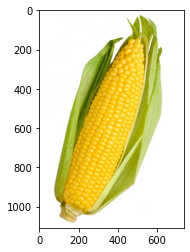

1/1 [==============================] - 0s 128ms/step
[[0.0342992  0.03179435 0.03225011 0.05535646 0.03383838 0.04519001
  0.03178493 0.02813716 0.03352604 0.0257447  0.03043465 0.0354212
  0.02156665 0.02751723 0.02459254 0.03569063 0.03087219 0.02844774
  0.03590978 0.03108253 0.04032227 0.02413542 0.0317864  0.02569037
  0.02873478 0.02549317 0.03133499 0.02869888 0.02906583 0.03003982
  0.02483245 0.02640918]]
3
[0.05535646]
Class: bell pepper
 Confidence score: 0.055356458


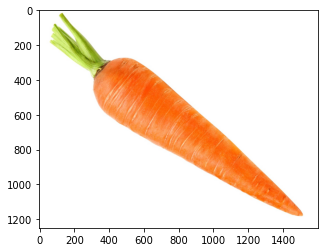

1/1 [==============================] - 0s 83ms/step
[[0.03291867 0.02979284 0.02438211 0.03545597 0.03139403 0.03784593
  0.03156802 0.03069292 0.03783539 0.02826146 0.02606907 0.0349549
  0.0290637  0.02659706 0.04015933 0.04557931 0.02815942 0.03088634
  0.03741746 0.03160515 0.03017994 0.02354837 0.03047153 0.02508813
  0.03608273 0.02652946 0.03055582 0.02687536 0.02946833 0.03060419
  0.02828392 0.03167312]]
15
[0.04557931]
Class: lemon
 Confidence score: 0.045579307


In [ ]:
#from google.colab.patches import cv2_imshow
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
image1 = Image.open(PATH + '/attest/Fruits and Vegetables/test/corn/Image_4.jpg').convert('RGB')
plt.imshow(image1)
plt.show()
size = (224, 224)
image1 = ImageOps.fit(image1, size, Image.Resampling.LANCZOS)
image_array = np.asarray(image1)
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
data[0] = normalized_image_array
prediction = model.predict(data)
print(prediction)
index = np.argmax(prediction)
print(index)
print(prediction[:,index])
class_name = class_names[index]
confidence_score = prediction[0][index]

print('Class:', class_name, end=' ')
print('Confidence score:', confidence_score)

image2 = Image.open(PATH + '/attest/Fruits and Vegetables/test/carrot/Image_2.jpg').convert('RGB')
plt.imshow(image2)
plt.show()
size = (224, 224)
image2 = ImageOps.fit(image2, size, Image.Resampling.LANCZOS)
image_array = np.asarray(image2)
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
data[0] = normalized_image_array
prediction = model.predict(data)
print(prediction)
index = np.argmax(prediction)
print(index)
print(prediction[:,index])
class_name = class_names[index]
confidence_score = prediction[0][index]

print('Class:', class_name, end=' ')
print('Confidence score:', confidence_score)

In [ ]:
""" Былы попытка использовать предобученную модель MobileNetV2, но особой разницы замечено не было. """

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

model = keras.Sequential([
    pretrained_model, 
    Dense(128, activation='relu'),
    Dense(32, activation='softmax')
])

# loss: 1.0592 - accuracy: 0.7605

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
